In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# all require package
## for analysis
import pandas as pd
import re
import os
import openai
from time import sleep
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yfinance as yf
from collections import Counter
## for plot
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
# from plotly import offline
# offline.init_notebook_mode(connected = False)
# pio.renderers.default = 'iframe'
pio.renderers.default = 'svg'
import numpy as np 
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junokat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Sentiment Analysis for Tickers from Analysis Result Data

In [50]:
data_df = pd.read_csv('./analysis_result_top10.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          53187 non-null  object 
 1   score          53187 non-null  int64  
 2   id             53187 non-null  object 
 3   url            53187 non-null  object 
 4   comms_num      53187 non-null  int64  
 5   created        53187 non-null  float64
 6   body           53187 non-null  object 
 7   timestamp      53187 non-null  object 
 8   ticker symbol  53187 non-null  object 
 9   GME            53187 non-null  bool   
 10  AMC            53187 non-null  bool   
 11  DD             53187 non-null  bool   
 12  WSB            53187 non-null  bool   
 13  HOLD           53187 non-null  bool   
 14  YOLO           53187 non-null  bool   
 15  BB             53187 non-null  bool   
 16  US             53187 non-null  bool   
 17  BUY            53187 non-null  bool   
 18  NOK   

In [51]:
import matplotlib.pyplot as plt

In [52]:

sia = SentimentIntensityAnalyzer()

# Assuming 'body' is the column containing text data
data_df['sentiment_score'] = data_df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [53]:
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization to create a new column
data_df['sentiment_category'] = data_df['sentiment_score'].apply(categorize_sentiment)

# Create new columns for each ticker indicating whether the sentiment is positive or negative
tickers = ['GME', 'AMC', 'DD', 'WSB', 'HOLD', 'YOLO', 'BB', 'US', 'BUY', 'NOK']
for ticker in tickers:
    ticker_col = f'{ticker}_Sentiment'
    
    data_df[ticker_col] = data_df.apply(lambda row: row['sentiment_category'] if row[ticker] else 'NA', axis=1)

# Drop the 'sentiment_category' column if you no longer need it
data_df.drop('sentiment_category', axis=1, inplace=True)

# Print the updated DataFrame
print(data_df)

                                                   title  score      id   
0      It's not about the money, it's about sending a...     55  l6ulcx  \
1      Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                        Exit the system      0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4      Not to distract from GME, just thought our AMC...     71  l6ufgy   
...                                                  ...    ...     ...   
53182    What I Learned Investigating SAVA FUD Spreaders    238  owd2pn   
53183  Daily Popular Tickers Thread for August 02, 20...    228  owd1a5   
53184       Hitler reacts to the market being irrational   7398  owc5dr   
53185        Daily Discussion Thread for August 02, 2021    338  owbfjf   
53186  Fraternal Association of Gambling Gentlemen an...     40  owaqd6   

                                                     url  comms_num   
0                        htt

## Save the file 

In [54]:
columns_to_delete = ['GME', 'AMC', 'DD', 'WSB','HOLD', 'YOLO', 'BB', 'US', 'BUY', 'NOK']

# Drop multiple columns
data_df = data_df.drop(columns=columns_to_delete)

In [8]:
# Save the DataFrame to a CSV file
data_df.to_csv('./sentiment_for_analysis_top10.csv', index=False)

## Visualise the Sentiments of Top 10 tickers

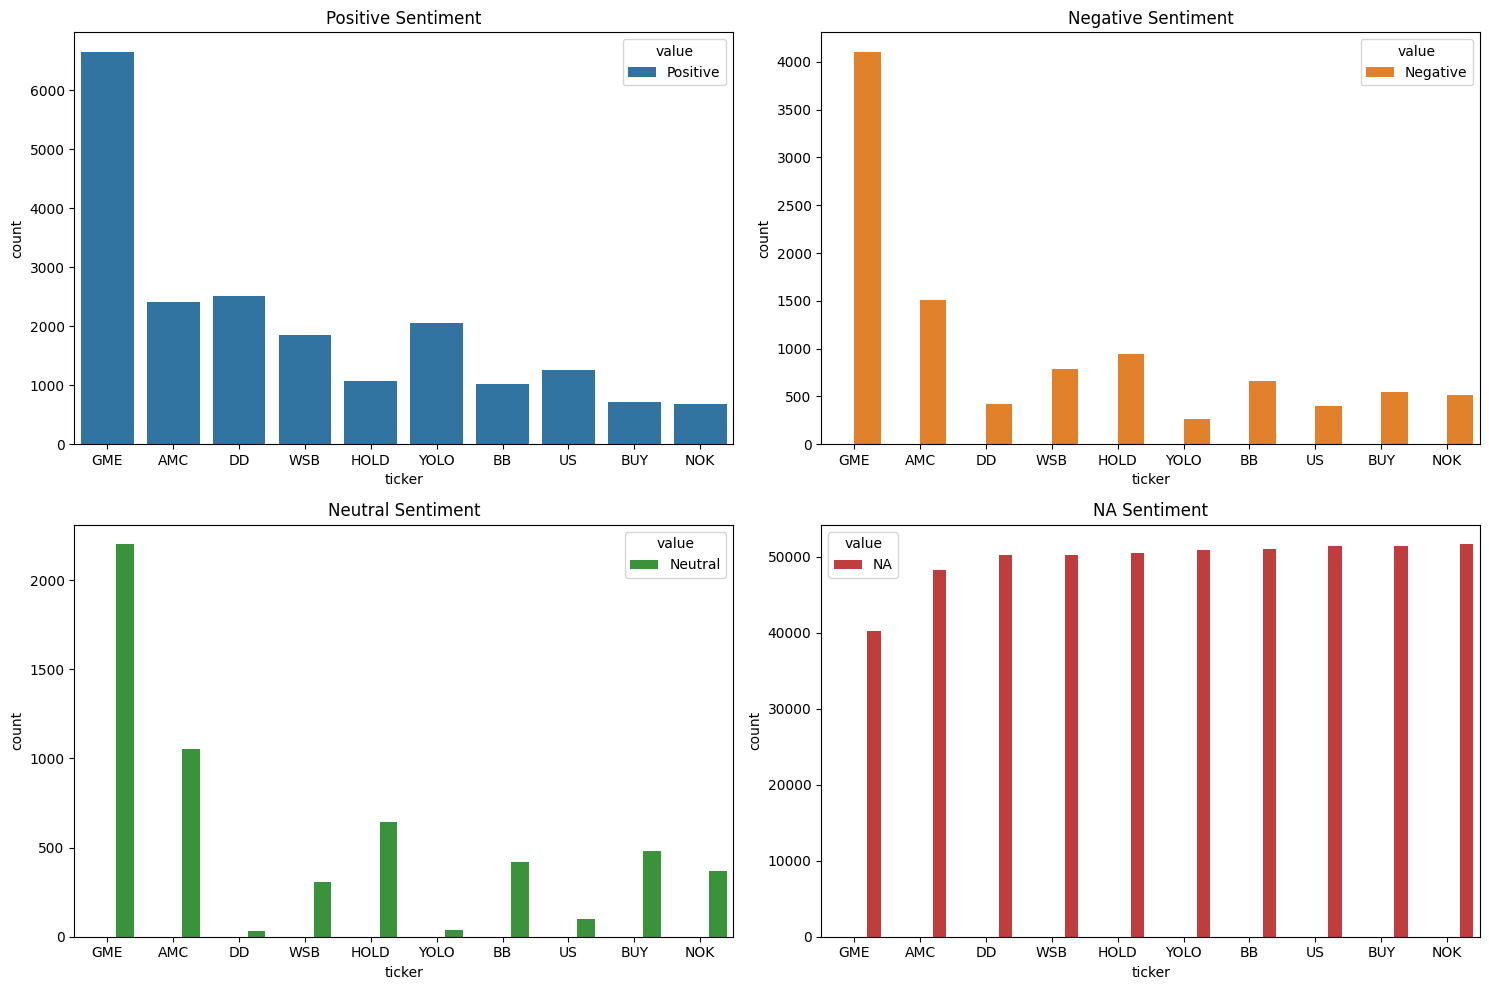

In [55]:

# Extract tickers from column names
tickers = [col.replace('_Sentiment', '') for col in data_df.columns if col.endswith('_Sentiment')]

# Create DataFrames for each sentiment (filtering only positive sentiment)
positive_sentiments_df = pd.DataFrame({ticker: data_df[data_df[f"{ticker}_Sentiment"] == 'Positive'][f"{ticker}_Sentiment"] for ticker in tickers})
negative_sentiments_df = pd.DataFrame({ticker: data_df[data_df[f"{ticker}_Sentiment"] == 'Negative'][f"{ticker}_Sentiment"] for ticker in tickers})
neutral_sentiments_df = pd.DataFrame({ticker: data_df[data_df[f"{ticker}_Sentiment"] == 'Neutral'][f"{ticker}_Sentiment"] for ticker in tickers})
na_sentiments_df = pd.DataFrame({ticker: data_df[data_df[f"{ticker}_Sentiment"] == 'NA'][f"{ticker}_Sentiment"] for ticker in tickers})

# Plot the bar plots for each sentiment with tickers 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Positive Sentiment
sns.countplot(ax=axes[0, 0], x='ticker', hue='value', data=positive_sentiments_df.melt(var_name='ticker'), hue_order=['Positive'])
axes[0, 0].set_title('Positive Sentiment')

# Negative Sentiment
sns.countplot(ax=axes[0, 1], x='ticker', hue='value', data=negative_sentiments_df.melt(var_name='ticker'), hue_order=['','Negative'])
axes[0, 1].set_title('Negative Sentiment')

# Neutral Sentiment
sns.countplot(ax=axes[1, 0], x='ticker', hue='value', data=neutral_sentiments_df.melt(var_name='ticker'), hue_order=['','','Neutral'])
axes[1, 0].set_title('Neutral Sentiment')

# NA Sentiment
sns.countplot(ax=axes[1, 1], x='ticker', hue='value', data=na_sentiments_df.melt(var_name='ticker'), hue_order=['','','','NA'])
axes[1, 1].set_title('NA Sentiment')

# Adjust layout
plt.tight_layout()
plt.show()

# Sentiment Analysis for Tickers from ChatGPT data

In [40]:
data_df = pd.read_csv('./gpt_analysis_result_top10.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      911 non-null    object 
 1   score      911 non-null    int64  
 2   id         911 non-null    object 
 3   url        911 non-null    object 
 4   comms_num  911 non-null    int64  
 5   created    911 non-null    float64
 6   body       911 non-null    object 
 7   timestamp  911 non-null    object 
 8   response   911 non-null    object 
 9   GME        537 non-null    float64
 10  CLOV       26 non-null     float64
 11  BB         47 non-null     float64
 12  TSLA       13 non-null     float64
 13  WSB        14 non-null     float64
 14  RKT        22 non-null     float64
 15  AMC        113 non-null    float64
 16  SLV        13 non-null     float64
 17  NOK        34 non-null     float64
 18  PLTR       15 non-null     float64
dtypes: float64(11), int64(2), object(6)
memory usage: 

In [41]:
import pandas as pd

# Assuming data_df is your DataFrame with the mentioned columns
columns_to_replace = ['GME', 'CLOV', 'BB', 'TSLA', 'WSB', 'RKT', 'AMC', 'SLV', 'NOK', 'PLTR']
for column in columns_to_replace:
    data_df[column] = data_df[column].replace(np.nan, 3)



In [42]:
# Mapping for replacement
replacement_mapping = {
    1: 'Positive',
    0: 'Neutral',
    2: 'Negative',
    3: 'NA'
}

# Loop through each column and apply the replacement mapping after converting to strings
for column in columns_to_replace:
    data_df[column] = data_df[column].replace(replacement_mapping)

# Display the updated DataFrame
print(data_df)

                                                 title  score      id   
0                    GME Megathread for March 10, 2021  47667  m1xhlc  \
1    GME Megathread for Wednesday, February 24th, 2021  28975  lre2k6   
2      GME What About Second Breakfast Club Megathread  29356  l7v9o8   
3                        GME Breakfast Club Megathread  25561  l7s631   
4                    GME Megathread for March 08, 2021  30653  m0fpgd   
..                                                 ...    ...     ...   
906                        Super Wallstreet Bros. Bets  25270  p0z1e6   
907  $GME INFINITY WAR Update from the front lines ...   5004  l6qij9   
908  Daily Popular Tickers Thread for July 19, 2021...    351  onb0bi   
909  $62k YOLO into $AMC pray for me. I don’t usual...   1936  nl62th   
910  Cathie Wood's ARK purchased more than 1 millio...   2113  mf6jig   

                                                   url  comms_num   
0    https://www.reddit.com/r/wallstreetbets/commen...

## Save the data

In [43]:
# Save the DataFrame to a CSV file
data_df.to_csv('./sentiment_for_gpt_top10.csv', index=False)

## Visualise the Sentiments of Top 10 tickers

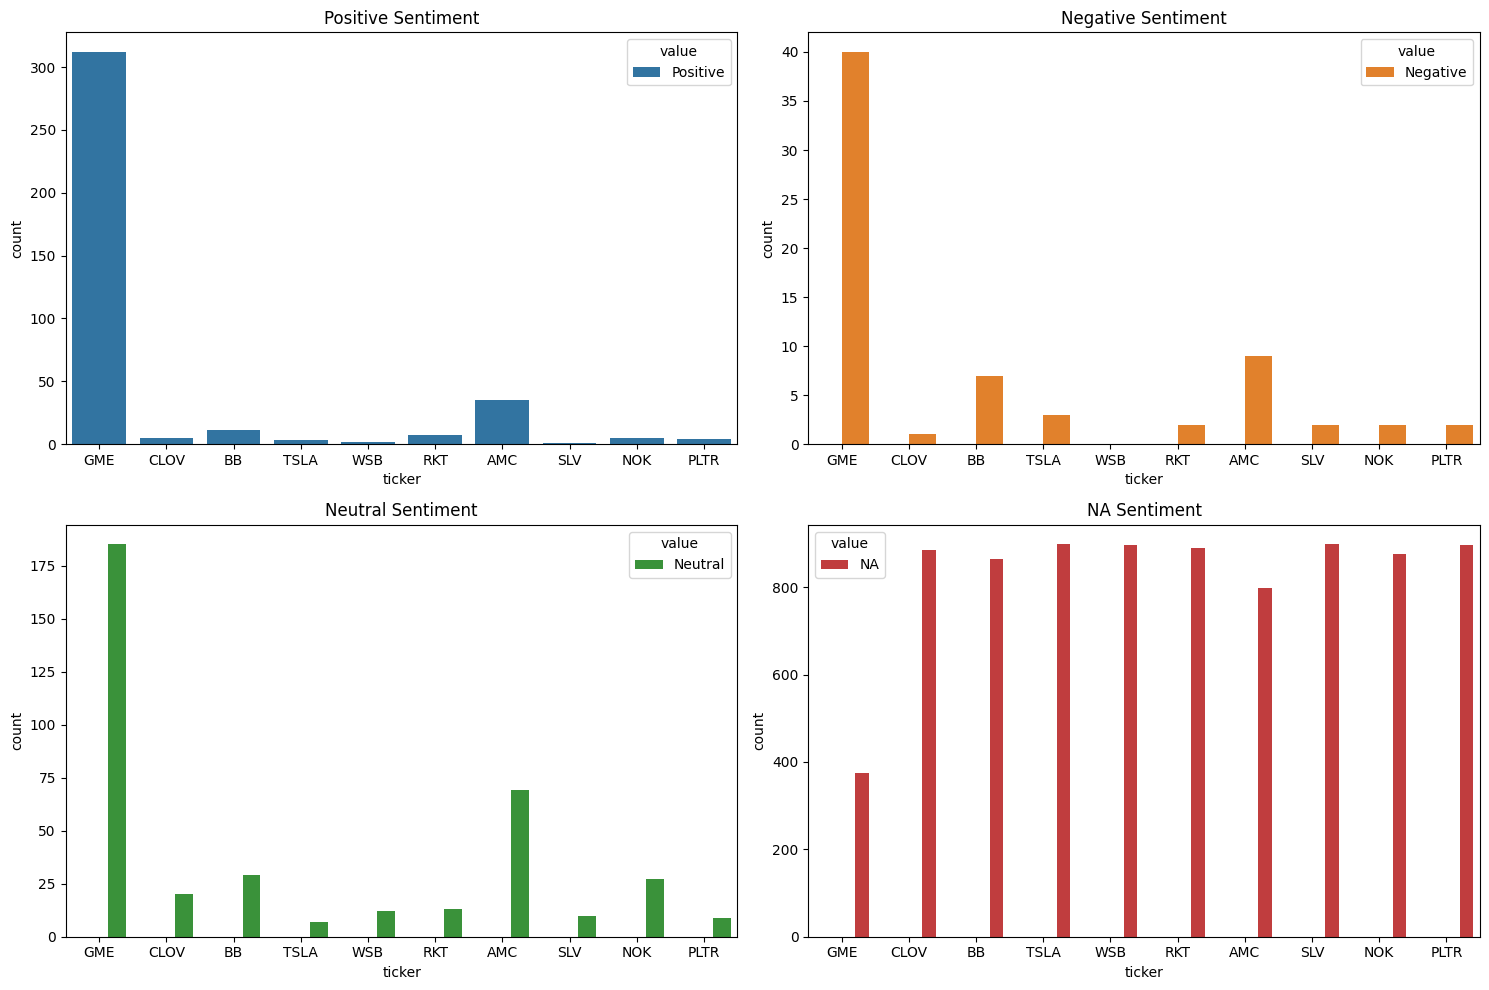

In [49]:

# Extract tickers from column names
tickers = ['GME', 'CLOV', 'BB', 'TSLA', 'WSB', 'RKT', 'AMC', 'SLV', 'NOK', 'PLTR']

# Create DataFrames for each sentiment (filtering only positive sentiment)
positive_sentiments_df = pd.DataFrame({ticker: data_df[data_df[ticker] == 'Positive'][ticker] for ticker in tickers})
negative_sentiments_df = pd.DataFrame({ticker: data_df[data_df[ticker] == 'Negative'][ticker] for ticker in tickers})
neutral_sentiments_df = pd.DataFrame({ticker: data_df[data_df[ticker] == 'Neutral'][ticker] for ticker in tickers})
na_sentiments_df = pd.DataFrame({ticker: data_df[data_df[ticker] == 'NA'][ticker] for ticker in tickers})

# Plot the bar plots for each sentiment with tickers 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Positive Sentiment
sns.countplot(ax=axes[0, 0], x='ticker', hue='value', data=positive_sentiments_df.melt(var_name='ticker'), hue_order=['Positive'])
axes[0, 0].set_title('Positive Sentiment')

# Negative Sentiment
sns.countplot(ax=axes[0, 1], x='ticker', hue='value', data=negative_sentiments_df.melt(var_name='ticker'), hue_order=['','Negative'])
axes[0, 1].set_title('Negative Sentiment')

# Neutral Sentiment
sns.countplot(ax=axes[1, 0], x='ticker', hue='value', data=neutral_sentiments_df.melt(var_name='ticker'), hue_order=['','','Neutral'])
axes[1, 0].set_title('Neutral Sentiment')

# NA Sentiment
sns.countplot(ax=axes[1, 1], x='ticker', hue='value', data=na_sentiments_df.melt(var_name='ticker'), hue_order=['','','','NA'])
axes[1, 1].set_title('NA Sentiment')

# Adjust layout
plt.tight_layout()
plt.show()
